In [54]:
import random
import matplotlib.pyplot as plt
import numpy as np

class Agent:

    def __init__(self):
        self.money = 0
        self.class_type = 'middle'

    def consume(self, seller, amount):
          self.money -= amount
          seller.money += amount

In [84]:
class Simulation:
    def __init__(self, num_agents, num_time_steps):
        self.num_agents = num_agents
        self.num_time_steps = num_time_steps
        self.agents = [Agent() for _ in range(num_agents)]
        self.total_tax = 0
        self.update_thresholds()
        self.update_wealth()
        self.segregate_agents()

        # Lists to track wealth and class of specific agents
        self.rich_agent_wealth = []
        self.middle_agent_wealth = []
        self.poor_agent_wealth = []
        self.rich_agent_classes = []
        self.middle_agent_classes = []
        self.poor_agent_classes = []

    def update_wealth(self):
        # Generate random wealth values based on specified percentages
        wealth_values = [random.uniform(0.1, 3) for _ in range(int(0.5 * self.num_agents))] + [random.uniform(3, 12) for _ in range(int(0.4 * self.num_agents))] + [random.uniform(12, 50) for _ in range(int(0.1 * self.num_agents))]
        random.shuffle(wealth_values)

        # Update agent wealth values
        for i, agent in enumerate(self.agents):
            agent.money = wealth_values[i]


    def calculate_tax(self, wealth):
        scaled_slab_1 = 3
        scaled_slab_2 = 6
        scaled_slab_3 = 9
        scaled_slab_4 = 12
        scaled_slab_5 = 15

        if wealth <= scaled_slab_1:
            return 0
        elif wealth <= scaled_slab_2:
            return 0.05 * (wealth - scaled_slab_1)
        elif wealth <= scaled_slab_3:
            return 0.1 * (wealth - scaled_slab_2) + 0.05 * (scaled_slab_2 - scaled_slab_1)
        elif wealth <= scaled_slab_4:
            return 0.15 * (wealth - scaled_slab_3) + 0.05 * (scaled_slab_2 - scaled_slab_1) + 0.1 * (scaled_slab_3 - scaled_slab_2)
        elif wealth <= scaled_slab_5:
            return 0.2 * (wealth - scaled_slab_4) + 0.05 * (scaled_slab_2 - scaled_slab_1) + 0.1 * (scaled_slab_3 - scaled_slab_2) + 0.15 * (scaled_slab_4 - scaled_slab_3)
        else:
            return 0.3 * (wealth - scaled_slab_5) + 0.05 * (scaled_slab_2 - scaled_slab_1) + 0.1 * (scaled_slab_3 - scaled_slab_2) + 0.15 * (scaled_slab_4 - scaled_slab_3) + 0.2 * (scaled_slab_5 - scaled_slab_4)

    def update_agents(self):
      # Select two random agents
      random_indices = random.sample(range(self.num_agents), 2)
      agent1, agent2 = self.agents[random_indices[0]], self.agents[random_indices[1]]

      # Base trade probability
      trade_probab = 0.07  # Lower base probability to reduce fluctuations

      # Increase probability if agents are from the same class
      if agent1.class_type == agent2.class_type:
          trade_probab = 0.15

      # Modify probability based on the class interaction
      if (agent1.class_type == 'rich' and agent2.class_type == 'poor') or (agent2.class_type == 'rich' and agent1.class_type == 'poor'):
          trade_probab *= 0.45  # Decrease probability for rich-poor trades to reduce significant disruptions
      if(agent1.class_type =='rich') or (agent2.class_type=='poor'):
        trade_probab*=0.45
      if(agent2.class_type == 'rich'):
        trade_probab*=1.75

      if random.random() < trade_probab:
          # Transaction amount is a smaller fraction of the lesser wealth to minimize disruption
          transaction_amount = 0.075 * (agent1.money * agent2.money) / (agent1.money + agent2.money)
          agent1.consume(agent2, transaction_amount)


    def deduct_tax(self):
        for agent in self.agents:
            tax = self.calculate_tax(agent.money)
            agent.money -= tax
            self.total_tax += tax

    def redist(self):
        add_val = self.total_tax / self.num_agents
        for agent in self.agents:
            agent.money += add_val
        self.total_tax = 0

    def update_thresholds(self):
        wealths = [agent.money for agent in self.agents]
        sorted_wealths = np.sort(wealths)

        self.lower_threshold = np.percentile(sorted_wealths, 50)  # 50th percentile
        self.upper_threshold = np.percentile(sorted_wealths, 90)  # 90th percentile

    def segregate_agents(self):
        for agent in self.agents:
            if agent.money <= self.lower_threshold:
                agent.class_type = 'poor'
            elif agent.money >= self.upper_threshold:
                agent.class_type = 'rich'
            else:
                agent.class_type = 'middle'

    def select_and_track_agents(self):
        random.shuffle(self.agents)
        for agent in self.agents:
            if agent.class_type == 'rich':
                self.rich_agent = agent
                break

        for agent in self.agents:
            if agent.class_type == 'middle':
                self.middle_agent = agent
                break

        for agent in self.agents:
            if agent.class_type == 'poor':
                self.poor_agent = agent
                break

        self.rich_agent_wealth.append(self.rich_agent.money)
        self.middle_agent_wealth.append(self.middle_agent.money)
        self.poor_agent_wealth.append(self.poor_agent.money)

        self.rich_agent_classes.append(self.rich_agent.class_type)
        self.middle_agent_classes.append(self.middle_agent.class_type)
        self.poor_agent_classes.append(self.poor_agent.class_type)

    def record_agent_classes(self):
        self.rich_agent_classes.append(self.rich_agent.class_type)
        self.middle_agent_classes.append(self.middle_agent.class_type)
        self.poor_agent_classes.append(self.poor_agent.class_type)

    def run_simulation(self):
        for _ in range(self.num_time_steps):
            self.update_agents()
        self.deduct_tax()
        self.redist()


In [56]:
def gini_coefficient(wealths):
    n = len(wealths)
    if n == 0:
        return 0

    # Step 1: Sort the wealth list
    sorted_wealths = np.sort(wealths)

    # Step 2: Calculate the mean absolute difference
    diff_matrix = np.abs(sorted_wealths[:, None] - sorted_wealths)
    mean_abs_diff = np.mean(diff_matrix)

    # Step 3: Compute the mean wealth
    mean_wealth = np.mean(sorted_wealths)

    # Step 4: Compute the Gini coefficient
    gini_index = mean_abs_diff / (2 * mean_wealth)
    return gini_index


Iteration  1  complete
Iteration  2  complete
Iteration  3  complete
Iteration  4  complete
Iteration  5  complete
Iteration  6  complete
Iteration  7  complete
Iteration  8  complete
Iteration  9  complete
Iteration  10  complete
Iteration  11  complete
Iteration  12  complete
Iteration  13  complete
Iteration  14  complete
Iteration  15  complete
Iteration  16  complete
Iteration  17  complete
Iteration  18  complete
Iteration  19  complete
Iteration  20  complete
Iteration  21  complete
Iteration  22  complete
Iteration  23  complete
Iteration  24  complete
Iteration  25  complete
Iteration  26  complete
Iteration  27  complete
Iteration  28  complete
Iteration  29  complete
Iteration  30  complete
Iteration  31  complete
Iteration  32  complete
Iteration  33  complete
Iteration  34  complete
Iteration  35  complete
Iteration  36  complete
Iteration  37  complete
Iteration  38  complete
Iteration  39  complete
Iteration  40  complete
Iteration  41  complete
Iteration  42  complete
I

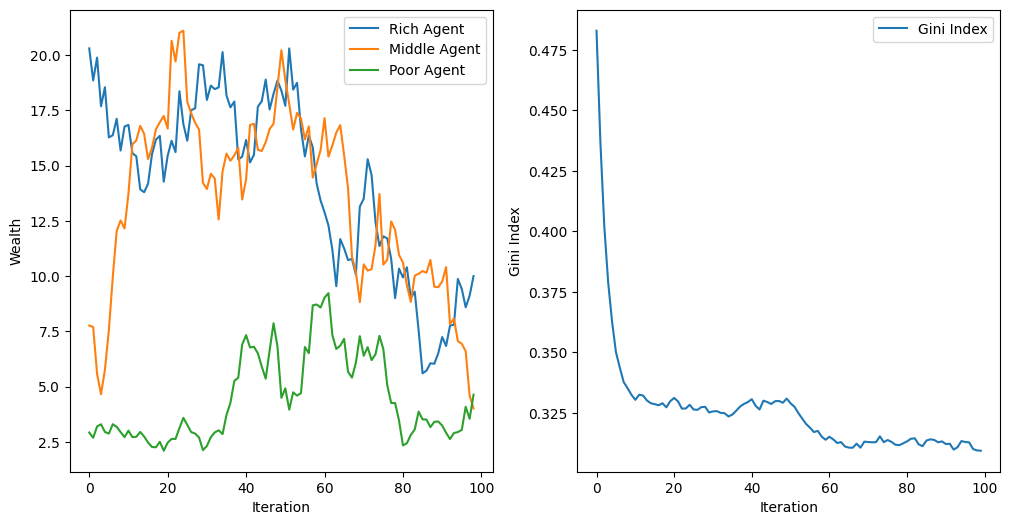

Rich Agent changed class 5 times.
Middle Agent changed class 7 times.
Poor Agent changed class 6 times.


In [95]:
# Simulation parameters
num_agents = 1000
num_time_steps = 100000
gini_indices= []
# Initialize the simulation
sim = Simulation(num_agents, num_time_steps)

# Run simulation for a total of 500 iterations, segregating after each redistribution
for i in range(100):
    sim.run_simulation()
    if i % 50 == 0:  # Update thresholds every 50 iterations
        sim.update_thresholds()
    sim.segregate_agents()
    if i == 1:  # Select agents to track after initial segregation
        sim.select_and_track_agents()
    elif i>1:
        # Record wealth and class of the tracked agents
        sim.rich_agent_wealth.append(sim.rich_agent.money)
        sim.middle_agent_wealth.append(sim.middle_agent.money)
        sim.poor_agent_wealth.append(sim.poor_agent.money)

        sim.record_agent_classes()
    current_wealths = [agent.money for agent in sim.agents]
    gini_index = gini_coefficient(current_wealths)
    gini_indices.append(gini_index)
    print("Iteration ", i + 1, " complete")

# Plot the wealth of the tracked agents
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sim.rich_agent_wealth, label='Rich Agent')
plt.plot(sim.middle_agent_wealth, label='Middle Agent')
plt.plot(sim.poor_agent_wealth, label='Poor Agent')
plt.xlabel('Iteration')
plt.ylabel('Wealth')
plt.legend()

# Plot the Gini coefficient over iterations
plt.subplot(1, 2, 2)
plt.plot(gini_indices, label='Gini Index')
plt.xlabel('Iteration')
plt.ylabel('Gini Index')
plt.legend()

plt.show()
# Analyze class changes
def analyze_class_changes(agent_classes, agent_label):
    changes = 0
    for i in range(1, len(agent_classes)):
        if agent_classes[i] != agent_classes[i - 1]:
            changes += 1
    print(f"{agent_label} changed class {changes} times.")

analyze_class_changes(sim.rich_agent_classes, "Rich Agent")
analyze_class_changes(sim.middle_agent_classes, "Middle Agent")
analyze_class_changes(sim.poor_agent_classes, "Poor Agent")



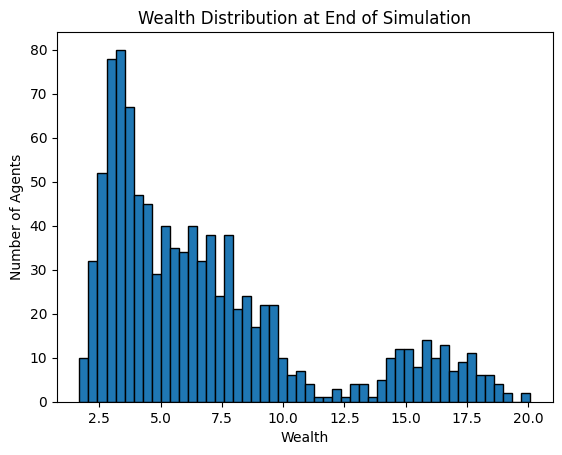

In [86]:
wealths = [agent.money for agent in sim.agents]
plt.hist(wealths, bins=50, edgecolor='black')
plt.xlabel('Wealth')
plt.ylabel('Number of Agents')
plt.title('Wealth Distribution at End of Simulation')
plt.show()

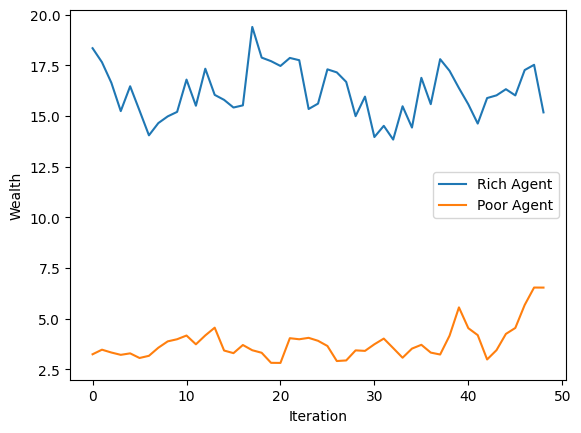

In [88]:
# Plot the wealth of the tracked agents
plt.plot(sim.rich_agent_wealth, label='Rich Agent')
# plt.plot(sim.middle_agent_wealth, label='Middle Agent')
plt.plot(sim.poor_agent_wealth, label='Poor Agent')
plt.xlabel('Iteration')
plt.ylabel('Wealth')
plt.legend()
plt.show()

In [89]:
# import seaborn as sns
# plt.style.use("bmh")
# sns.kdeplot(flattened_wealth_distributions, bw_adjust=0.5, fill=True, alpha=0.6)

# # Set titles and labels
# plt.title("Wealth Distribution", size=17, pad=10)
# plt.xlabel("Wealth")
# plt.ylabel("Density")
# plt.grid(False)

# # Set x-ticks
# plt.xticks(range(0, int(max(flattened_wealth_distributions)) + 100, 500))

# # Show the plot
# plt.show()


In [90]:
np.mean(gini_indices)

0.3414020875231094

In [91]:
gini_indices[-1]

0.3337648413308291